# Guided Project: ML | Predicting Bike Rentals

The goal of this project is to compare the performance of various ML models on the task of predicting hourly bike rentals.

The dataset contains 17380 observations of hourly bike share data from Washington, DC. In addition volume data, features include information about the local weather, the rider, and the day. The dataset was compiled by [Hadi Fanaee-T ad the University of Porto](http://www.liaad.up.pt/area/fanaee) and can be downloaded [here](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import describe
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

## Data Import

In [2]:
df = pd.read_csv("bike_rental_hour.csv")
print(df.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


#### Relevant column descriptions:

- **instant** - A unique sequential ID number for each row
- **dteday** - The date of the rentals
- **season** - The season in which the rentals occurred
- **yr** - The year the rentals occurred
- **mnth** - The month the rentals occurred
- **hr** - The hour the rentals occurred
- **holiday** - Whether or not the day was a holiday
- **weekday** - The day of the week (as a number, 0 to 7)
- **workingday** - Whether or not the day was a working day
- **weathersit** - The weather (as a categorical variable)
- **temp** - The temperature, on a 0-1 scale
- **atemp** - The adjusted temperature
- **hum** - The humidity, on a 0-1 scale
- **windspeed** - The wind speed, on a 0-1 scale
- **casual** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- **registered** - The number of registered riders (people who had already signed up)
- **cnt** - The total number of bike rentals (casual + registered)

## Target

The target column for prediction is **'cnt'**, which is the total number of bike rentals for the observed hour.

Hourly bike rentals range from 1-977 with a mean of 189. The distribution is right skewed and indicates that the majority of hours are low volume, but that there are certain hours with substantial peaks. We'll want a model that handles these demand spikes well.

In [3]:
#### Descriptive Stats
df['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

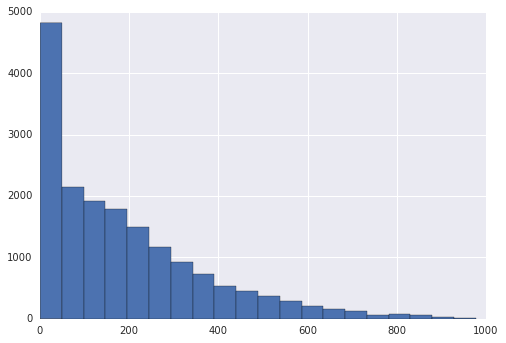

In [4]:
# Frequency
df['cnt'].hist(bins=20)

## Feature Correlation w/Target

#### Temperature

Higher temperature hours tend to have higher rental rates.

- **temp** -  Temperature normalized 0-1 based on -8C - 38C range.
- **atemp** - The temperature that it "feels like".

#### Humidity

Lower humidity hours tend to have higher rental rates.

- **hum** - Normalized humidity. The values are divided to 100 (max).

#### Other weather fields

- Weather situation (**weathersit**) shows that it may influence the outcome of the model, however; it will need to be preprocessed before it is useful.

- **windspeed** shows a weak positive correlation with rental rates.

#### Temporal fields

Several fields include data about time including; season, mnth, and hour. These fields, particularly hr, do show some correlation with rentals, however; they will require some preprocessing before insights can be derived.

In [5]:
corrs = df.corr()
corrs = corrs['cnt'].drop(['instant', 'registered', 'casual', 'cnt', 'yr'])
print(corrs)

season        0.178056
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
Name: cnt, dtype: float64


## Feature Engineering

#### Hours - Add Daypart Feature

It may be helpful later to have the option of looking at hours in groups based on the part of the day that they are in - morning, afternoon, evening or overnight. This step will add a label ['daypart'] and then convert to k-1 dummy variables.

In [6]:
## Group hours by morning/afternoon dayparts etc.
def assign_daypart(val):
    if ((val >= 6) & (val < 12)):   #Morning
        return 1
    elif ((val >= 12) & (val < 18)):  #Afternoon
        return 2
    elif ((val >= 18) & (val < 24)):  #Evening
        return 3
    else:  #Overnight
        return 4
    
#Add daypart dummies
df['daypart'] = df['hr'].apply(assign_daypart)
daypart_dummies = pd.get_dummies(df['daypart'], prefix='daypart', drop_first=True)
df = pd.concat([df, daypart_dummies], axis=1)
#df = df.drop('daypart', axis=1)

#### Hours option 2: sine and cosine transform

Although hours 0 and 23 are separated by only a second, a machine learning model will not understand their cyclical nature in their current state. Instead, it would see jump discontinuity between 23 and 0. One potential solution is to transform hours into to separate variables expressed in sin and cos functions. This technique is discussed in more depth [here](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/).

This technique may improve linear regression models, but will not be useful in a random forest as the sin and cos components won't be considered together.

In [7]:
#sine and cosine tranform hrs
df['sin_time'] = np.sin(2*np.pi*df.hr/24)
df['cos_time'] = np.cos(2*np.pi*df.hr/24)

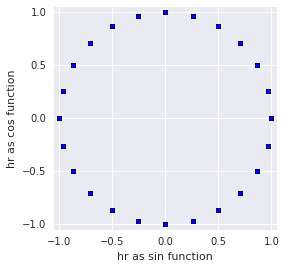

In [8]:
#visualize resulting (sin, cos) hrs
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(df['sin_time'], df['cos_time'])
plt.xlim(-1.05,1.05)
plt.ylim(-1.05,1.05)
plt.xlabel('hr as sin function')
plt.ylabel('hr as cos function')
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

## Other cyclical features

While we're at it, the **mnth**, **weekday**, and **season** features may also benefit from this tranformation. Of the three, I'll only be including weekday in the models and opting to include the number of days from the beginning of the year instead of month or season.

In [9]:
df['sin_weekday'] = np.sin(2*np.pi*df.weekday/7)
df['cos_weekday'] = np.cos(2*np.pi*df.weekday/7)
#df = df.drop(['mnth', 'season'], axis=1)

#### Day

For the day (of the year) feature, it would make sense to have two versions available; day of the year expressed in days since Dec 31st and day of the year expressed as sin+cos functions.

In [10]:
#convert to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

#calc day of the year / drop original col
def day_of_year(val):
    jan_one = datetime(year=val.year, month=1, day=1)
    return (val - jan_one).days + 1

df['day_of_year'] = df['dteday'].apply(day_of_year)
df = df.drop(['dteday'], axis=1)

#apply sin/cos transformation to day_of_year (keep original also)
df['sin_day_of_year'] = np.sin(2*np.pi*df.day_of_year/365)
df['cos_day_of_year'] = np.cos(2*np.pi*df.day_of_year/365)

#### Casual / registered users

Casual/registered user fields are a decomposition of the target variable, so it doesn't make sense to include them as predictors of the target. We would not know these figures when making predictions on new data.

In [11]:
df = df.drop(['registered', 'casual'], axis=1)

#### Weather situation

Weather situation is a non-continuous categorical value that should be converted to dummy k-1 variables.

In [12]:
#Add weathersit dummies
weathersit_dummies = pd.get_dummies(df['weathersit'], prefix='weathersit', drop_first=True)
df = pd.concat([df, weathersit_dummies], axis=1)
#df = df.drop('weathersit', axis=1)

#### Collinearity

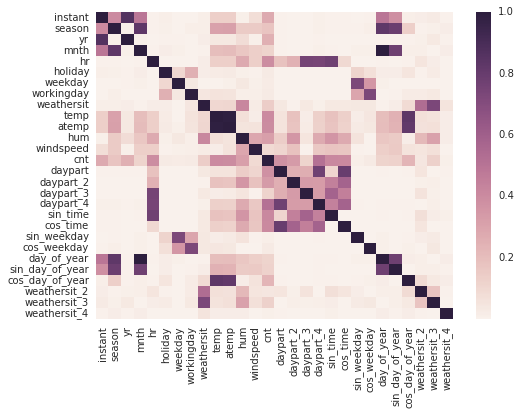

In [13]:
corrs = df.corr().abs()
sns.heatmap(corrs)

#### Drop temp

Adjusted temp ('atemp') and temp contribute virtually the same information.

In [14]:
df = df.drop(['temp'], axis=1)

In [15]:
df.columns

Index(['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt',
       'daypart', 'daypart_2', 'daypart_3', 'daypart_4', 'sin_time',
       'cos_time', 'sin_weekday', 'cos_weekday', 'day_of_year',
       'sin_day_of_year', 'cos_day_of_year', 'weathersit_2', 'weathersit_3',
       'weathersit_4'],
      dtype='object')

## Feature lists

Organizing features by lists for potential inclusion in each model type.

**Linear Regression:**
- 'yr', 
- Time of Day Options (pick one only):
 1. ['daypart_2', 'daypart_3', 'daypart_4']
 2. ['sin_time', 'cos_time']
 3. 'hr'
- 'holiday', 
- 'sin_weekday', 
- 'cos_weekday',
- 'workingday', 
- 'atemp', 
- 'hum',
- 'windspeed',
Pick one day option:
- - 'day_of_year'
- - ['sin_day_of_year', 'cos_day_of_year'] 
- 'weathersit_2', 
- 'weathersit_3',
- 'weathersit_4'

**Random Forest:**
- 'yr'
- 'holiday', 
- 'weekday', 
- 'workingday', 
- 'atemp', 
- 'hum',
- 'windspeed',  
- 'day_of_year', 
- 'weathersit_2', 
- 'weathersit_3',
- 'weathersit_4'
- Time of day options (pick one):
- - 'daypart_2', 'daypart_3', 'daypart_4'
- - 'hr'

# Linear Regression

The first model I'm testing will be Linear Regression with kfolds cross-validation. The cost function we're trying to minimize is root_mean_squared_error (RMSE).

#### Result

After testing several configurations of this model, I was able to predict bike rentals with a 151.7 RMSE. This result is not accurate enough to create a reliable forecast for operations and will likely be outperformed by a decision tree or random forest model.

## Check feature priorities

In [16]:
#group features
day_part = ['daypart_2', 'daypart_3', 'daypart_4']
sin_cos_time = ['sin_time', 'cos_time']
univariate_features = ['yr','holiday','workingday','atemp','hum','windspeed']
sin_cos_doy = ['sin_day_of_year','cos_day_of_year']
weathersit = ['weathersit_2','weathersit_3','weathersit_4']
sin_cos_weekday = ['sin_weekday','cos_weekday']

In [17]:
#Train/Test/Crossvalidate Function. If n_folds=1, holdout validation only.
def train_test_kfold(a_dataframe, feature_list, n_folds=1):
    #Shuffle data
    data = a_dataframe.copy()
    data = data.sample(frac=1, random_state=1)
    
    #Holdout Validation
    if n_folds == 1:
        #partition 50/50 split
        last_row = int(np.floor(data.shape[0] * .5))
        test = data[:last_row]
        train = data[last_row:]
        
        #train
        lr = LinearRegression()
        lr.fit(train[feature_list], train['cnt'])
        
        #predict test data, calc error
        test_predictions = lr.predict(test[feature_list])
        test_mse = mean_squared_error(y_true=test['cnt'], y_pred=test_predictions)
        test_rmse = np.sqrt(test_mse)
        
        return test_rmse
    
    #KFolds cross-validation
    if n_folds > 1: 
        kf = KFold(n_splits=n_folds)
        rmse_values = []
        for train_index, test_index, in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            lr = LinearRegression()
            lr.fit(train[feature_list], train['cnt'])
            predictions = lr.predict(test[feature_list])
            mse = mean_squared_error(test['cnt'], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse

#### Compare time of day options

Earlier, I created a few options for time of day.
 - **"hr"**: hour of the day on 0-23 scale
 - **"daypart"**: hour of the day grouped in 6 hour blocks and expressed as 3 (k-1) dummy variables.
 - **'sin_time' and 'cos_time'**: 'hr' represented by two variables, sin and cos transformations.
 
After testing each independently, the **sin_cos_time** option will be used moving forward as it produces the most accurate predictions.

In [18]:
print("hr: {}".format(train_test_kfold(df, ['hr'], n_folds=5)))
print("daypart: {}".format(train_test_kfold(df, day_part, n_folds=5)))
print("sin_cos_time: {}".format(train_test_kfold(df, sin_cos_time, n_folds=5)))

hr: 166.67569301079567
daypart: 151.6054933228764
sin_cos_time: 147.710815885106


#### Compare date options
Like time of day, we have a few choices for incorporating dates:
- **'day_of_year'**: number of days since 12/31
- **'sin_day_of_year'** and '**cos_day_of_year'**: number of days since 12/31 expressed as sin and cos variables

Again, the sine/cosine tranformations outperform the original, so we'll stick with them for this model.

In [19]:
print("day_of_year: {}".format(train_test_kfold(df, ['day_of_year'], n_folds=5)))
print("sin_cos_doy: {}".format(train_test_kfold(df, sin_cos_doy, n_folds=5)))

day_of_year: 180.05604957175768
sin_cos_doy: 174.89987838291452


#### Compare remaining features

In [20]:
feature_rmses = {}
for col in univariate_features:
    feature_rmses[col] = train_test_kfold(df, [col], n_folds=5)
    
feature_rmses['weathersit'] = train_test_kfold(df, weathersit, n_folds=5)
feature_rmses['sin_cos_weekday'] = train_test_kfold(df, sin_cos_weekday, n_folds=5)

for key, value in sorted(feature_rmses.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, int(value)))

atemp: 166
hum: 171
yr: 175
weathersit: 179
windspeed: 180
holiday: 181
workingday: 181
sin_cos_weekday: 181


In [21]:
print(train_test_kfold(df, ["atemp", "hum", "yr"] + weathersit + ['windspeed', 'holiday', 'workingday'] + sin_cos_weekday, n_folds=5))
print(train_test_kfold(df, ["atemp", "hum", "yr"] + weathersit + ['windspeed', 'holiday', 'workingday'], n_folds=5))
print(train_test_kfold(df, ["atemp", "hum", "yr"] + weathersit + ['windspeed', 'holiday'], n_folds=5))
print(train_test_kfold(df, ["atemp", "hum", "yr"] + weathersit + ['windspeed'], n_folds=5))
print(train_test_kfold(df, ["atemp", "hum", "yr"] + weathersit, n_folds=5))
print(train_test_kfold(df, ["atemp", "hum", "yr"], n_folds=5))
print(train_test_kfold(df, ["atemp", "hum"], n_folds=5))

151.76749842694863
151.77340912744563
151.77049834869985
151.83004727867723
151.95493169762787
152.12471060610284
156.8384460204832


# Decision Tree Model

A decision tree model proves to be a better approach to this problem. After some pre-pruning (constraining the min_samples_split to 20 and max_depth to 10) the tree model was able to predict rental counts with less than half of the RMSE score compared to the LinearRegression model.



In [22]:
#Model function
def decision_tree(dataframe, features, min_samples_leaf, 
                  min_samples_split, max_depth, max_features):
    #shuffle
    data = dataframe.copy()
    data = data.sample(frac=1, random_state=1)
    
    #partition
    last_row = int(data.shape[0] * .8)
    test = data[:last_row]
    train = data[last_row:]
    
    #define and fit model on training data
    model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, 
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  max_features=max_features,
                                  random_state=1)
    
    model.fit(train[features], train['cnt'])
    
    #predict train data (for overfitting assessment)
    predictions_train = model.predict(train[features])
    
    #predict test data
    predictions = model.predict(test[features])
    
    #measure errors
    mse_train = mean_squared_error(y_true=train['cnt'], y_pred=predictions_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_true=test['cnt'], y_pred=predictions)
    rmse_test = np.sqrt(mse_test)
    
    return rmse_train, rmse_test


In [23]:
#Feature selection
features = list(df.columns)
remove_cols = ['cnt', 'sin_day_of_year', 
               'cos_day_of_year', 'weathersit_2', 
               'weathersit_3', 'weathersit_4',
                'cos_time', 'sin_time', 
               'sin_weekday', 'cos_weekday',
              'daypart_2', 'daypart_3', 'daypart_4']
for col in remove_cols:
    if col in features:
        features.remove(col)
print(features)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'daypart', 'day_of_year']


In [24]:
#Experiment with pre-pruning options
tree = decision_tree(df, 
                    features, 
                    min_samples_leaf=1, 
                    min_samples_split=20,
                    max_depth=10, 
                    max_features=11
                   )
print(tree)

(67.3887218514423, 84.93799582794841)


# Random Forest Model

The decision tree was a big improvement over regression, but there is plenty of room left in the cost function to keep exploring. Next up is random forest trees.

#### Result

The random forest model further improved predictions, reducing RMSE from 75 to 49.

In [25]:
#Model function
def random_forest(dataframe, n_estimators, features, min_samples_leaf, 
                  min_samples_split, max_depth, max_features, max_leaf_nodes=None):
    #shuffle
    data = dataframe.copy()
    data = data.sample(frac=1, random_state=1)
    
    #partition
    last_row = int(data.shape[0] * .8)
    test = data[:last_row]
    train = data[last_row:]
    
    #define and fit model on training data
    model = RandomForestRegressor(bootstrap=True,
                                  n_estimators=n_estimators,
                                  min_samples_leaf=min_samples_leaf, 
                                  max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  max_features=max_features,
                                  max_leaf_nodes=max_leaf_nodes,
                                  random_state=1)
    
    model.fit(train[features], train['cnt'])
    
    #predict train data (for overfitting assessment)
    predictions_train = model.predict(train[features])
    
    #predict test data
    predictions = model.predict(test[features])
    
    #measure errors
    mse_train = mean_squared_error(y_true=train['cnt'], y_pred=predictions_train)
    rmse_train = np.sqrt(mse_train)
    mse_test = mean_squared_error(y_true=test['cnt'], y_pred=predictions)
    rmse_test = np.sqrt(mse_test)
    
    return rmse_train, rmse_test


In [26]:
#Feature selection
features = list(df.columns)
remove_cols = ['cnt', 'weathersit', 'daypart', 'weekday', 'sin_day_of_year', 'cos_day_of_year']

for col in remove_cols:
    if col in features:
        features.remove(col)
print(features)

['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'daypart_2', 'daypart_3', 'daypart_4', 'sin_time', 'cos_time', 'sin_weekday', 'cos_weekday', 'day_of_year', 'weathersit_2', 'weathersit_3', 'weathersit_4']


In [27]:
#Experiment with pre-pruning options
forest = random_forest(df,
                    n_estimators=50,
                    features=features,
                    min_samples_leaf=1, 
                    min_samples_split=2,
                    max_depth=18, 
                    max_features='auto',
                    max_leaf_nodes=None
                   )
print(forest)

(20.223146220894087, 49.73011068089806)
